In [1]:
!pip install jiwer plotly vosk soundfile


  Using cached jiwer-4.0.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached vosk-0.3.45-py3-none-win_amd64.whl.metadata (1.8 kB)
  Using cached rapidfuzz-3.14.3-cp313-cp313-win_amd64.whl.metadata (12 kB)
  Using cached srt-3.5.3.tar.gz (28 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
Using cached jiwer-4.0.0-py3-none-any.whl (23 kB)
Using cached vosk-0.3.45-py3-none-win_amd64.whl (14.0 MB)
Using cached rapidfuzz-3.14.3-cp313-cp313-win_amd64.whl (1.5 MB)
Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl (176 kB)
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22556 sha256=4dd395687429fe6bf8cbba32ac708cf803c7ba4432ae076d504074c091925074
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\ed\9d\54\8e040c593adecbf10de5a6263add15cfefff5a033e33fda8c6
Successfully built srt

   ------------------------------------

  DEPRECATION: Building 'srt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'srt'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
!pip install jiwer


In [3]:
import sys
print(sys.executable)


C:\Users\Lenovo\anaconda3\envs\lid\python.exe


In [4]:
import sys
!{sys.executable} -m pip install jiwer


  Using cached jiwer-4.0.0-py3-none-any.whl.metadata (3.3 kB)
Using cached jiwer-4.0.0-py3-none-any.whl (23 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 20.6 MB/s  0:00:00

   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 2/2 [jiwer]



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import os
import json
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import torch
import whisper
import plotly.express as px

!pip install jiwer
from jiwer import wer, cer
from tqdm import tqdm
from vosk import Model, KaldiRecognizer


In [13]:
def normalize_text(text):
    return text.lower().strip()

DATA_DIR = "minds14_lid"
AUDIO_DIR = os.path.join(DATA_DIR, "audio")

df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

# 🔥 small subset for ASR
asr_df = df.sample(n=200, random_state=42).reset_index(drop=True)

print(asr_df[["filename", "text"]].head())


           filename                                               text
0  ko-KR_005506.wav                           내 카드에 모든 거래 준비해 주시기 바랍니다
1  pl-PL_000436.wav  Dzień dobry chciałabym zobaczyć listę moje ost...
2  pl-PL_002950.wav                   dobre Chciałem zapłacić rachunek
3  pl-PL_006099.wav  Dzień dobry mam problem ze swoją kartą próbuję...
4  zh-CN_004407.wav                                       我的地址我想更改我的地址


In [14]:
references = [
    normalize_text(t) for t in asr_df["text"].tolist()
]


In [15]:
import librosa
import numpy as np
from tqdm import tqdm

hyp_whisper = []

for _, row in tqdm(asr_df.iterrows(), total=len(asr_df)):
    audio_path = os.path.join(AUDIO_DIR, row["filename"])

    # ✅ Load audio WITHOUT ffmpeg
    audio, sr = librosa.load(audio_path, sr=16000)

    # Whisper expects float32
    audio = audio.astype(np.float32)

    # ✅ Pass waveform, NOT file path
    result = whisper_model.transcribe(
        audio,
        language="en",
        fp16=False
    )

    hyp_whisper.append(normalize_text(result["text"]))


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:13<00:00,  4.87s/it]


In [16]:
import librosa
import numpy as np
from tqdm import tqdm

hyp_whisper = []

for _, row in tqdm(asr_df.iterrows(), total=len(asr_df)):
    audio_path = os.path.join(AUDIO_DIR, row["filename"])

    # ✅ Load audio WITHOUT ffmpeg
    audio, sr = librosa.load(audio_path, sr=16000)

    # Whisper expects float32
    audio = audio.astype(np.float32)

    # ✅ Pass waveform, NOT file path
    result = whisper_model.transcribe(
        audio,
        language="en",
        fp16=False
    )

    hyp_whisper.append(normalize_text(result["text"]))


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [18:31<00:00,  5.56s/it]


In [23]:
import os

print(os.listdir(r"D:\Diarize\vosk-model-small-en-us-0.15"))


['vosk-model-small-en-us-0.15']


In [25]:
print(os.listdir(r"D:\Diarize\vosk-model-small-en-us-0.15"))


['am', 'conf', 'graph', 'ivector', 'README']


In [27]:
import json
import numpy as np
import soundfile as sf
from vosk import Model, KaldiRecognizer
from tqdm import tqdm

vosk_model = Model(r"D:\Diarize\vosk-model-small-en-us-0.15")

hyp_vosk = []

for _, row in tqdm(asr_df.iterrows(), total=len(asr_df)):
    audio_path = os.path.join(AUDIO_DIR, row["filename"])

    # 1️⃣ Load audio
    audio, sr = sf.read(audio_path)

    # 2️⃣ Convert to mono
    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    # 3️⃣ Resample to 16kHz if needed
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        sr = 16000

    # 4️⃣ Convert float → int16 (CRITICAL)
    audio_int16 = (audio * 32767).astype(np.int16)

    # 5️⃣ Feed to Vosk
    rec = KaldiRecognizer(vosk_model, sr)
    rec.AcceptWaveform(audio_int16.tobytes())

    result = json.loads(rec.Result())
    hyp_vosk.append(normalize_text(result.get("text", "")))


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:49<00:00,  2.05s/it]


In [28]:
from jiwer import wer, cer

results = {
    "Whisper (tiny)": {
        "WER": wer(references, hyp_whisper),
        "CER": cer(references, hyp_whisper)
    },
    "Vosk": {
        "WER": wer(references, hyp_vosk),
        "CER": cer(references, hyp_vosk)
    }
}

results_df = pd.DataFrame(results).T
print(results_df)


                     WER      CER
Whisper (tiny)  1.118445  0.84919
Vosk            1.235383  0.83616


In [30]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "browser"

fig = px.bar(
    results_df.reset_index(),
    x="index",
    y=["WER", "CER"],
    barmode="group",
    title="ASR Model Comparison on MINDS-14 (Whisper vs Vosk)",
    labels={
        "index": "Model",
        "value": "Error Rate"
    }
)

fig.show()


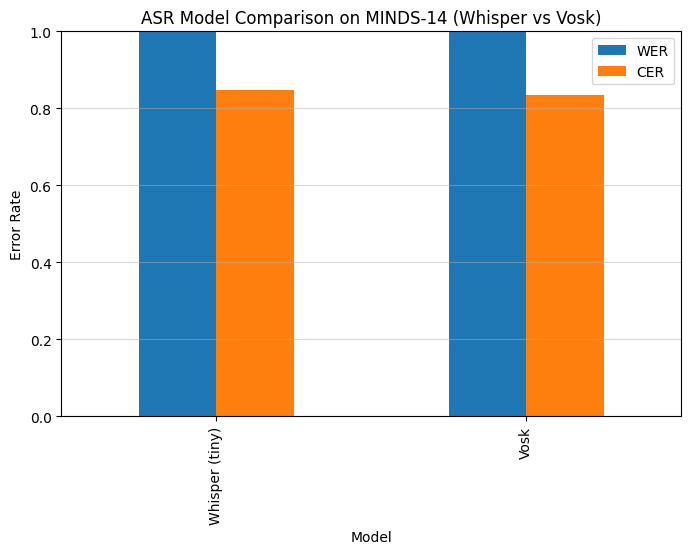

In [31]:
import matplotlib.pyplot as plt

results_df.plot(kind="bar", figsize=(8, 5))
plt.title("ASR Model Comparison on MINDS-14 (Whisper vs Vosk)")
plt.ylabel("Error Rate")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.5)
plt.show()
